## FinBERT Sentiment Analysis

#### Import Packages

In [13]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"    # avoid TF backend import
os.environ["TRANSFORMERS_NO_FLAX"] = "1"  # avoid Flax


#### FinBERT Model Setup

In [17]:

MODEL = "ProsusAI/finbert"

if "model" not in globals():
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(DEVICE).eval()
    print(f"Loaded FinBERT on {DEVICE}.")
else:
    # (optional) if CUDA becomes available later, move it
    new_device = "cuda" if torch.cuda.is_available() else "cpu"
    if str(next(model.parameters()).device) != new_device:
        model.to(new_device).eval()
        DEVICE = new_device
        print(f"Moved model to {DEVICE}.")
    else:
        print("Model already loaded; skipping.")

id2label = model.config.id2label  # {0:'positive',1:'negative',2:'neutral'}


Model already loaded; skipping.


#### Function Definitions

In [ ]:
def finbert_proba(texts, batch_size=32, device=DEVICE, max_length=256):
    """
    Return a list of dicts: [{'negative': p, 'neutral': p, 'positive': p}, ...]
    """
    all_probs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            ).to(device)
            logits = model(**enc).logits
            probs = F.softmax(logits, dim=-1).cpu().tolist()
            for p in probs:
                # map indices -> labels dict
                out = {id2label[j]: float(p[j]) for j in range(len(p))}
                # ensure all three keys exist
                for k in ("negative", "neutral", "positive"):
                    out.setdefault(k, 0.0)
                all_probs.append(out)
    return all_probs

# def sentiment_label(texts, neutrality_threshold=1):
#     """
#     Map each text to 'positive'/'negative'/'neutral' after thresholding.
#     """
#     probs = finbert_proba(texts)
#     labels = []
#     for p in probs:
#         if p["neutral"] >= neutrality_threshold:
#             labels.append("neutral")
#         else:
#             labels.append("positive" if p["positive"] > p["negative"] else "negative")
#     return labels

def top2_margin(p: dict) -> float:
    """
    Return max_prob - second_prob in [0,1].
    """
    vals = sorted([p["negative"], p["neutral"], p["positive"]], reverse=True)
    return float(vals[0] - vals[1])

def sentiment_score(texts):
    """
    Continuous score per text: 0 if too neutral (currently 100% neutral or pos = neg), else (pos - neg).
    Useful for weighting by Reddit score later.
    """
    probs = finbert_proba(texts)
    scores = []
    for p in probs:
        base = (p["positive"] - p["negative"])           
        neutral_damp = (1.0 - p["neutral"])              
        margin_damp = top2_margin(p)                           
        scores.append(base * neutral_damp * margin_damp)
    return scores

# tanh with 30D window
def tanh_scale_series(scores, timestamps=None, percentile=95, min_periods=14):
    """
    30D rolling P95 tanh scaling.
    - scores: array-like of signed Reddit scores (ups - downs)
    - timestamps: array-like of datetimes aligned with scores (if None -> global P95)
    Returns:
      w: np.ndarray in [-1, 1] (tanh-scaled, sign preserved)
      k_used: np.ndarray of per-row k values (rolling P95 of |score|)
    """
    s = np.asarray(scores, dtype=float)
    if s.size == 0:
        return s.astype(float), np.array([], dtype=float)
    s = np.nan_to_num(s, nan=0.0)

    if timestamps is not None:
        ts = pd.to_datetime(pd.Series(timestamps), utc=True, errors="coerce")
        abs_s = pd.Series(np.abs(s), index=ts).sort_index()
        roll_p = abs_s.rolling("30D", min_periods=min_periods).quantile(percentile/100.0)
        g_p = abs_s.quantile(percentile/100.0) if len(abs_s) else 1.0
        k_series = roll_p.fillna(g_p).clip(lower=1.0)
        # align per-row k back to original order (by timestamps)
        k_used = k_series.reindex(ts).to_numpy()
        # fallback for NaT rows
        k_used = np.where(np.isfinite(k_used), k_used, max(g_p, 1.0))
    else:
        # global P95
        g_p = np.percentile(np.abs(s), percentile) if s.size else 1.0
        k_used = np.full_like(s, fill_value=max(g_p, 1.0), dtype=float)

    w = np.tanh(s / k_used)
    return w.astype(float), k_used.astype(float)

# tanh scaling over whole dataset
# def tanh_scale_series(scores, k=None, percentile=95):
#     s = np.asarray(scores, dtype=float)
#     s = np.nan_to_num(s, nan=0.0)
#     if k is None:
#         # choose a robust scale from your own data
#         P = np.percentile(np.abs(s), percentile) if s.size else 1.0
#         k = max(P, 1.0)
#     w = np.tanh(s / k)  # w in [-1, 1], sign preserved
#     return w, float(k)

# without Tanh scaling.
# def score_multiplier(raw_sentiment_scores, reddit_scores):
#     """
#     Multiplies score per text by their Reddit score (Upvotes-Downvotes). 
#     """
#     scaled_reddit_scores = reddit_scores * w
#     for i in range(len(raw_sentiment_scores)):
#         scaled_sentiment_scores.append(raw_sentiment_scores[i] * scaled_reddit_scores[i])
#     return scaled_sentiment_scores

def score_multiplier(raw_sentiment_scores, reddit_scores, percentile=95):
    """
    raw_sentiment_scores: list/array of sentiment scores in [-1, 1]
    reddit_scores: list/array of signed Reddit scores (ups - downs)
    returns: list of crowd-adjusted scores in [-1, 1]
    """
    rs = np.asarray(raw_sentiment_scores, dtype=float)
    w, k_used = tanh_scale_series(reddit_scores, percentile=percentile)
    # elementwise combine; DO NOT multiply by raw reddit_scores again
    return (rs * w).tolist(), k_used


#### Running the Model on Data

In [71]:
# proper, multiple datasets lines below
file_locations ={"Amazon" : r"C:\Users\ftomi\Documents\GitHub\NLP-Group-10\companies_csv\Amazon_company_data.csv", 
                 "Apple" : r"C:\Users\ftomi\Documents\GitHub\NLP-Group-10\companies_csv\Apple_company_data.csv", 
                 "Tesla" : r"C:\Users\ftomi\Documents\GitHub\NLP-Group-10\companies_csv\Tesla_company_data.csv"} 


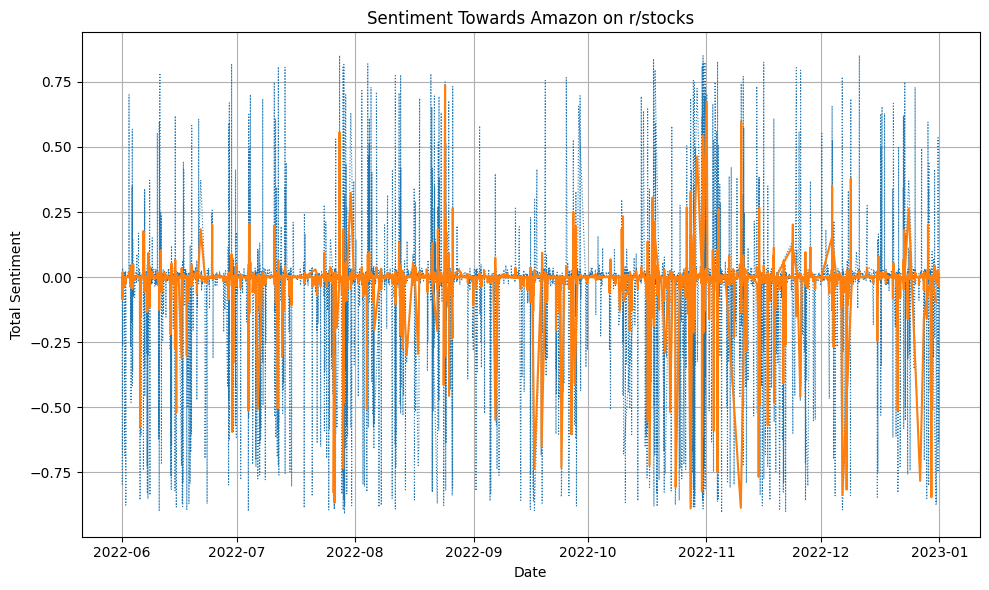

In [ ]:

# singular test line below
# file_locations = {"Amazon" : r"C:\Users\ftomi\Desktop\NLP project\Amazon_submissions.csv"}

for fl in file_locations:

    df = pd.read_csv(file_locations[fl])

    dates = []
    texts = []
    upvotes = [] 
    scaled_sentiment_scores = []
    raw_sentiment_scores = []

    data = df.to_dict('index')
    for i in range(len(data)):
        texts.append(data[i]['processed_text'])
        dates.append(datetime.fromtimestamp(data[i]['created_utc'], tz=timezone.utc))
        upvotes.append(data[i]['score'])

    probs = finbert_proba(texts)
    raw_sentiment_scores = sentiment_score(texts)
    scaled_sentiment_scores, k_used = score_multiplier(sentiment_score(texts), upvotes)
    
    # save as dataframe
    sentiment_df = pd.DataFrame(dict(scaled_sentiment = scaled_sentiment_scores, created_utc = dates))
    sentiment_df.to_csv(f"{fl}_sentiment_data.csv", index=False)

    #show and save figure
    plt.figure(figsize=(10,6))
    plt.plot(dates, raw_sentiment_scores, label = "raw",  linestyle=":", linewidth=0.8)
    plt.plot(dates, scaled_sentiment_scores, label = "scaled by reddit score")
    plt.title(f"Sentiment Towards {fl} on r/stocks")
    plt.xlabel("Date")
    plt.ylabel("Total Sentiment")
    plt.tight_layout()
    plt.grid()
    plt.savefig(f"{fl}_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

## Model Evaluation

#### Sample Selection

In [74]:
import random
random.seed(42) 

p = 0.002           

samples = []

for name, path in file_locations.items():   # dict: key=name, value=path
    df = pd.read_csv(path, skiprows=lambda i: (i > 0) and (random.random() > p))
    df["__source"] = name  # so we can see contributions
    print(f"{name} -> kept {len(df):,} rows from {os.path.basename(path)}")
    samples.append(df)

combined = pd.concat(samples, ignore_index=True)
print("\nPer-file rows kept:")
print(combined["__source"].value_counts())

combined.to_csv("FinBERT_TEST_SET.csv", index=False)
print("Wrote: FinBERT_TEST_SET.csv | rows:", len(combined))

Amazon -> kept 14 rows from Amazon_company_data.csv
Apple -> kept 20 rows from Apple_company_data.csv
Tesla -> kept 20 rows from Tesla_company_data.csv

Per-file rows kept:
__source
Apple     20
Tesla     20
Amazon    14
Name: count, dtype: int64
Wrote: FinBERT_TEST_SET.csv | rows: 54


#### Test

Using the file 'test_sample_annotated.csv' which is a redacted, human-annotated version of 'FinBERT_TEST_SET.csv'.

In [ ]:
test_sample_annotated = pd.read_csv(r"C:\Users\ftomi\Desktop\NLP project\test_sample_annotated.csv")

def finbert_evaluation(df):
    text_og = df["selftext"].astype(str).tolist()
    text_pp = df["processed_text"].astype(str).tolist()
    probs_og = finbert_proba(text_og, device=DEVICE)
    probs_pp = finbert_proba(text_pp, device=DEVICE)
    argmax_og = [max(p.items(), key=lambda kv: kv[1]) for p in probs_og]
    argmax_pp = [max(p.items(), key=lambda kv: kv[1]) for p in probs_pp]
    df["selftext_finbert_label"] = [k for k, v in argmax_og]
    df["selftext_finbert_score"] = [v for k, v in argmax_og]
    df["processed_finbert_label"] = [k for k, v in argmax_pp]
    df["processed_finbert_score"] = [v for k, v in argmax_pp]
    return df

# outputs in SAME folder as inputs
comments_test_complete = finbert_evaluation(test_sample_annotated)
comments_test_complete.to_csv("test_sample_complete.csv", index=False)


In [ ]:
comments = pd.read_csv(r"C:\Users\ftomi\Desktop\NLP project\comments_test_complete.csv")
subs = pd.read_csv(r"C:\Users\ftomi\Desktop\NLP project\submissions_test_complete.csv")

# --- helpers ---
def find_gold_col(df):
    for name in ["gold_score"]:
        if name in df.columns: 
            return name
    raise KeyError("Could not find the golden-standard column.")

def add_human_label(df):
    df = df.copy()
    gcol = find_gold_col(df)
    scores = pd.to_numeric(df[gcol], errors="coerce")
    mapping = {1: "positive", 0: "neutral", -1: "negative"}
    df["human_label"] = scores.map(mapping)
    return df

def eval_preds(df, pred_cols):
    """Return accuracy + confusion matrices for each predicted label column."""
    out = {}
    y_true = df["human_label"].str.lower()
    mask = y_true.notna()
    for col in pred_cols:
        y_pred = df[col].astype(str).str.lower()
        acc = float((y_pred[mask] == y_true[mask]).mean())
        cm = pd.crosstab(y_true[mask], y_pred[mask], dropna=False).reindex(
            index=["negative","neutral","positive"], columns=["negative","neutral","positive"], fill_value=0
        )
        out[col] = {"accuracy": acc, "confusion": cm}
    return out

def print_report(name, results):
    print(f"\n=== {name} ===")
    for col, r in results.items():
        print(f"\n{col}  —  accuracy: {r['accuracy']:.3f}")
        print(r["confusion"])
# ----------------

# add human labels
comments = add_human_label(comments)
subs     = add_human_label(subs)

# evaluate vs FinBERT labels (adjust column names if yours differ)
comment_results = eval_preds(
    comments, pred_cols=["selftext_finbert_label", "processed_finbert_label"]
)
subs_results = eval_preds(
    subs, pred_cols=["selftext_finbert_label", "processed_finbert_label"]
)

print_report("COMMENTS", comment_results)
print_report("SUBMISSIONS", subs_results)


=== COMMENTS ===

selftext_finbert_label  —  accuracy: 0.667
selftext_finbert_label  negative  neutral  positive
human_label                                        
negative                       0        2         0
neutral                        3        9         0
positive                       0        0         1

processed_finbert_label  —  accuracy: 0.800
processed_finbert_label  negative  neutral  positive
human_label                                         
negative                        0        2         0
neutral                         1       11         0
positive                        0        0         1

=== SUBMISSIONS ===

selftext_finbert_label  —  accuracy: 0.600
selftext_finbert_label  negative  neutral  positive
human_label                                        
negative                       0        2         0
neutral                        1        9         0
positive                       0        3         0

processed_finbert_label  —  accuracy: 0.66